## Monte Carlo Value Prediction Algorithm for Estimation 

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)
- [University of Alberta's RL specialization](https://www.coursera.org/specializations/reinforcement-learning)

&nbsp;

Based on policy usage, there are 2 types of RL algorithms:
- In **on-policy** algorithms, the same policy is used to generate samples and to do policy improvement.
- In **off-policy** algorithms, there are 2 different policies - one for generating samples and the other for policy improvement.
    - The policy being used to generate the samples is called the **behavior policy**. This policy has more exploratory nature (ie, higher $\varepsilon$ value). 
    - The policy being learned (maximized) is called the **target policy**. This policy has less exploratory nature (ie, lower $\varepsilon$ value).

In this notebook, the algorithms we'll be implementing are on-policy algorithms.

![First-visit MC Prediction](../algo_img/first_visit_mc_prediction.png "First-visit MC Prediction")

Source: [Reinforcement Learning (2nd ed) - An Introduction - Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html)

![Every-visit MC Prediction](../algo_img/every_visit_on-policy_mc_prediction.png "Every-visit MC Prediction")

In [4]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sns.set()

### Trying out MC Prediction on BlackJack environment

In [1]:
from IPython.display import Image
Image(url="https://gymnasium.farama.org/_images/blackjack.gif")

In [2]:
import gymnasium as gym
from blackjack.plot_utils import plot_policy, plot_win_rate

# create Blackjack environment
env = gym.make("Blackjack-v1", natural=False, sab=False)

In [11]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [15]:
# Create dictionary whose values are all arrays of 2 elements
# which are both 0.5.
# The 0.5 value implies that the 2 elements are both
# 50% probabilities
defaultdict(lambda: np.ones(2) / 2)

defaultdict(<function __main__.<lambda>()>, {})

In [7]:
def fn():
    n_actions = env.action_space.n
    print(n_actions)
    random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
    state = (19, 10, False)
    print(random_policy)
    random_policy[state]
    print(random_policy)
    print(np.argmax(random_policy[state]))
    

fn()

2
defaultdict(<function fn.<locals>.<lambda> at 0x7f4f3125dc10>, {})
defaultdict(<function fn.<locals>.<lambda> at 0x7f4f3125dc10>, {(19, 10, False): array([0.5, 0.5])})
0


In [24]:
def epsilon_greedy_strategy(env, epsilon, policy, state):
    if np.random.random() < epsilon:
        # take a random action
        return env.action_space.sample()
    else:
        # take the action with the highest value, ie, greedy action
        return np.argmax(policy[state])
    

In [25]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


In [27]:
def fn():
    V = defaultdict(float)
    V[(1,2,3)] = 5.46
    V[(4,5,6)] = 7.13
    return V

fn()

defaultdict(float, {(1, 2, 3): 5.46, (4, 5, 6): 7.13})

In [28]:
class MC_Prediction:
    def __init__(self, num_episodes, env, gamma, policy, epsilon, 
                 strategy, alpha=None):
        self.num_episodes = num_episodes
        self.env = env
        self.V = defaultdict(float)   # estimated state values
        self.N = defaultdict(int)     # visit count
        self.policy = policy
        self.gamma = gamma            # discount factor
        self.epsilon = epsilon        # exploration rate
        self.strategy = strategy      # action selection strategy
        self.alpha = alpha            # constant factor
        self.rewards_sum_fv = []
        self.rewards_sum_ev = []

    def generate_episode(self):
        state, _ = self.env.reset()
        episode = []
        while True:
            action = self.strategy(self.env, self.epsilon, 
                                   self.policy, state)
            next_state, reward, done, trunc, _ = env.step(action)
            episode.append((state, reward))
            state = next_state
            if (done or trunc):
                break
        return episode


    def first_visit(self):
        """
        This is the first-visit MC Value Prediction algorithm for estimation.
        Check pg. 80 of Nimish Sanghi's book for the pseudocode.
        """
        for _ in tqdm(range(self.num_episodes)):
            experience = self.generate_episode()
            states, rewards = zip(*experience)
            self.rewards_sum_fv.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, r = states[t], rewards[t]
                G = self.gamma * G + r
                if s not in states[:t]:
                    if self.alpha is not None:
                        self.V[s] = self.V[s] + self.alpha * (G - self.V[s])
                    else:
                        self.N[s] += 1
                        self.V[s] = self.V[s] + (1/self.N[s]) * (G - self.V[s])
        return self.V


    def every_visit(self):
        """
        This is the every-visit MC Value Prediction algorithm for estimation.
        """
        for _ in tqdm(range(self.num_episodes)):
            experience = self.generate_episode()
            states, rewards = zip(*experience)
            self.rewards_sum_ev.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, r = states[t], rewards[t]
                G = self.gamma * G + r
                if self.alpha is not None:
                    self.V[s] = self.V[s] + self.alpha * (G - self.V[s])
                else:
                    self.N[s] += 1
                    self.V[s] = self.V[s] + (1/self.N[s]) * (G - self.V[s])
        return self.V
    

In [74]:
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 10_000
env = gym.make("Blackjack-v1", natural=False, sab=False)
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [75]:
fv_mc = MC_Prediction(num_episodes, env, gamma, random_policy, epsilon, strategy)

In [76]:
fv_mc.generate_episode()

[((8, 4, 0), -1.0)]

In [77]:
fv_mc.first_visit()

100%|██████████| 10000/10000 [00:01<00:00, 5616.39it/s]


defaultdict(float,
            {(18, 4, 0): -0.15,
             (17, 10, 0): -0.6138613861386139,
             (15, 10, 0): -0.6282894736842105,
             (18, 5, 1): -0.3125,
             (7, 5, 0): 0.0,
             (15, 5, 0): -0.34210526315789475,
             (14, 10, 0): -0.6095238095238096,
             (7, 10, 0): -0.5,
             (19, 7, 1): 0.4,
             (8, 7, 0): -0.16666666666666666,
             (5, 7, 0): -0.6666666666666666,
             (18, 9, 0): -0.5357142857142857,
             (13, 10, 0): -0.5778546712802768,
             (18, 10, 0): -0.5427509293680297,
             (16, 10, 0): -0.6013289036544851,
             (10, 10, 0): -0.3971631205673759,
             (11, 10, 0): -0.6125,
             (15, 10, 1): -0.7297297297297297,
             (19, 10, 0): -0.40217391304347827,
             (12, 10, 0): -0.5474006116207951,
             (9, 9, 0): -0.5,
             (15, 1, 0): -0.927710843373494,
             (19, 1, 0): -0.4461538461538462,
             (

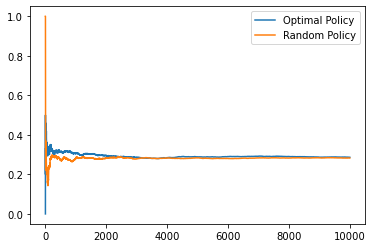

In [80]:
plot_win_rate(fv_mc.rewards_sum_fv, fv_mc.num_episodes)

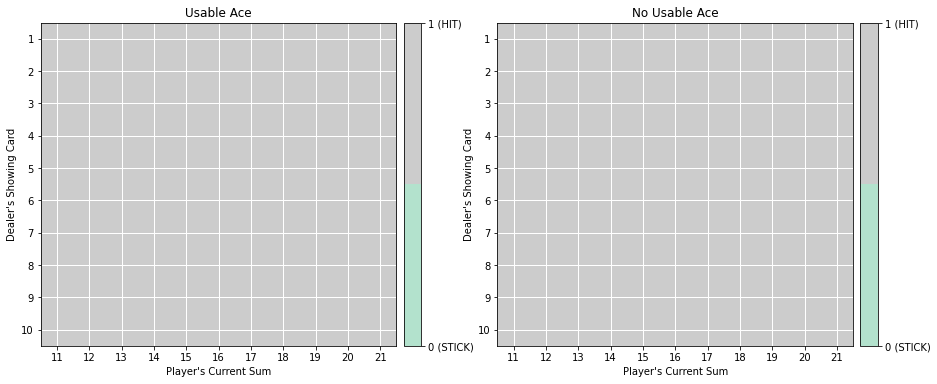

In [81]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(fv_mc.policy)

![Optimal Policy](./blackjack/optimal.png "Optimal Policy")

### Trying out MC Prediction on Cliff Walking environment

In [18]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [19]:
env = gym.make("CliffWalking-v0")

In [20]:
env.reset()

(36, {'prob': 1})

In [21]:
env.action_space.n

4

In [22]:
env.observation_space.n

48

In [33]:
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 1000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [34]:
fv_mc = MC_Prediction(num_episodes, env, gamma, random_policy, epsilon, strategy)

In [35]:
fv_mc.generate_episode()

[(36, -1),
 (24, -1),
 (24, -1),
 (25, -1),
 (26, -1),
 (27, -1),
 (28, -1),
 (29, -1),
 (30, -1),
 (18, -1),
 (30, -100),
 (36, -1),
 (36, -1),
 (24, -1),
 (24, -1),
 (25, -1),
 (24, -1),
 (36, -100),
 (36, -1),
 (36, -1),
 (24, -1),
 (25, -1),
 (24, -1),
 (12, -1),
 (0, -1),
 (0, -1),
 (1, -1),
 (1, -1),
 (2, -1),
 (14, -1),
 (15, -1),
 (16, -1),
 (28, -1),
 (16, -1),
 (28, -1),
 (29, -1),
 (17, -1),
 (29, -100),
 (36, -1),
 (36, -1),
 (36, -1),
 (36, -1),
 (24, -1),
 (36, -100),
 (36, -1),
 (24, -1),
 (36, -1),
 (24, -1),
 (12, -1),
 (0, -1),
 (1, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (12, -1),
 (24, -1),
 (24, -1),
 (25, -1),
 (26, -100),
 (36, -1),
 (36, -1),
 (36, -1),
 (24, -1),
 (24, -1),
 (24, -1),
 (24, -1),
 (36, -100),
 (36, -1),
 (36, -1),
 (24, -1),
 (25, -1),
 (13, -1),
 (14, -1),
 (26, -1),
 (25, -100),
 (36, -1),
 (24, -1),
 (12, -1),
 (0, -1),
 (0, -1),
 (1, -1),
 (13, -1),
 (1, -1),
 (2, -1),
 (2, -1),
 (2, -1),
 (3, -1),
 (2, -1

In [36]:
fv_mc.first_visit()

100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


defaultdict(float,
            {35: -33684.449000000044,
             23: -44597.77630121817,
             33: -58699.38988764044,
             11: -48084.80517879161,
             10: -52364.272222222186,
             22: -51784.42311770949,
             9: -55980.33050847461,
             21: -56666.563541666605,
             8: -58987.65364850981,
             7: -61318.761133603286,
             31: -64507.81008583688,
             32: -62489.683461117216,
             20: -60285.821649484526,
             19: -62644.79038854805,
             18: -64082.316378433345,
             30: -65601.54641350218,
             16: -65166.89759036145,
             17: -64736.54692230066,
             6: -63059.49849246223,
             5: -64358.270623742435,
             4: -64911.427281845565,
             3: -65342.788577154315,
             15: -65649.87048192775,
             2: -65649.0300601203,
             29: -65330.08205128208,
             28: -65626.09543147206,
             27: -

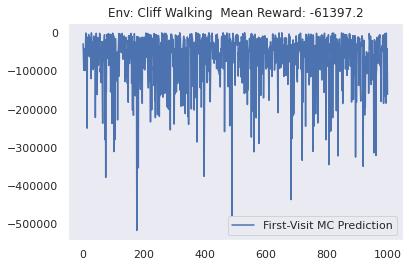

In [37]:
plot_rewards("Cliff Walking", fv_mc.rewards_sum_fv, "First-Visit MC Prediction")

In [38]:
env = gym.make("CliffWalking-v0")

In [39]:
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 1000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [40]:
ev_mc = MC_Prediction(num_episodes, env, gamma, random_policy, epsilon, strategy)

In [41]:
ev_mc.every_visit()

100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


defaultdict(float,
            {35: -34217.781167427376,
             23: -43434.846080043906,
             22: -50284.71470290903,
             21: -57128.14258988112,
             9: -57172.239779513366,
             8: -61010.89764516983,
             20: -61895.6591958181,
             7: -63956.985914668425,
             19: -64983.10995986882,
             18: -68173.95021143416,
             6: -66192.65063600593,
             5: -67751.71546250791,
             4: -68128.21930916692,
             16: -69004.51158170188,
             15: -69077.78274345364,
             3: -69003.03896571258,
             2: -69332.09885033163,
             14: -69324.70575062382,
             13: -69085.25226159517,
             12: -69152.60210004088,
             1: -68889.247800649,
             0: -68796.24732862221,
             24: -69353.48558698085,
             36: -69396.88670433471,
             25: -69414.53626269923,
             26: -69681.65345397539,
             27: -69216.5497

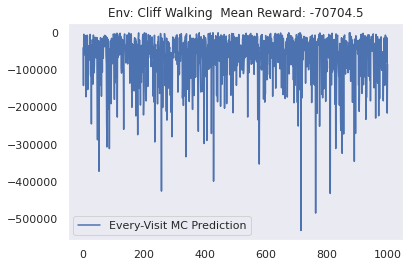

In [44]:
plot_rewards("Cliff Walking", ev_mc.rewards_sum_ev, "Every-Visit MC Prediction")

### Trying out MC Prediction on Taxi environment

In [ ]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [ ]:
env = gym.make("Taxi-v3")

In [ ]:
env.reset()

(208, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [ ]:
env.action_space.n

6

In [ ]:
env.observation_space.n

500

In [ ]:
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 10_000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [ ]:
fv_mc = MC_Prediction(num_episodes, env, gamma, random_policy, epsilon, strategy)

In [ ]:
fv_mc.generate_episode()

[((8, 4, 0), -1.0)]

In [ ]:
fv_mc.first_visit()

100%|██████████| 10000/10000 [00:01<00:00, 5616.39it/s]


defaultdict(float,
            {(18, 4, 0): -0.15,
             (17, 10, 0): -0.6138613861386139,
             (15, 10, 0): -0.6282894736842105,
             (18, 5, 1): -0.3125,
             (7, 5, 0): 0.0,
             (15, 5, 0): -0.34210526315789475,
             (14, 10, 0): -0.6095238095238096,
             (7, 10, 0): -0.5,
             (19, 7, 1): 0.4,
             (8, 7, 0): -0.16666666666666666,
             (5, 7, 0): -0.6666666666666666,
             (18, 9, 0): -0.5357142857142857,
             (13, 10, 0): -0.5778546712802768,
             (18, 10, 0): -0.5427509293680297,
             (16, 10, 0): -0.6013289036544851,
             (10, 10, 0): -0.3971631205673759,
             (11, 10, 0): -0.6125,
             (15, 10, 1): -0.7297297297297297,
             (19, 10, 0): -0.40217391304347827,
             (12, 10, 0): -0.5474006116207951,
             (9, 9, 0): -0.5,
             (15, 1, 0): -0.927710843373494,
             (19, 1, 0): -0.4461538461538462,
             (

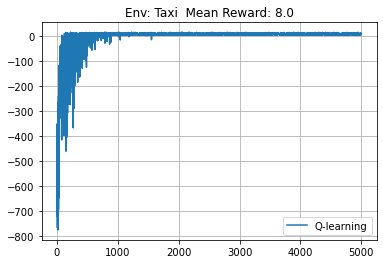

In [ ]:
plot_rewards("Taxi", fv_mc.rewards_sum_fv, "First-Visit MC Prediction")